<a href="https://colab.research.google.com/github/hkiiskin/ML-Project2-MS-Disease/blob/main/MS_Disease_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchmetrics
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 7.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Libraries

import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional import accuracy as ACC

from torchsummary import summary

import pytorch_lightning as pl

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               273 non-null    int64  
 1   Gender                   273 non-null    int64  
 2   Age                      273 non-null    int64  
 3   Schooling                273 non-null    float64
 4   Breastfeeding            273 non-null    int64  
 5   Varicella                273 non-null    int64  
 6   Initial_Symptom          273 non-null    float64
 7   Mono_or_Polysymptomatic  273 non-null    int64  
 8   Oligoclonal_Bands        273 non-null    int64  
 9   LLSSEP                   273 non-null    int64  
 10  ULSSEP                   273 non-null    int64  
 11  VEP                      273 non-null    int64  
 12  BAEP                     273 non-null    int64  
 13  Periventricular_MRI      273 non-null    int64  
 14  Cortical_MRI             2

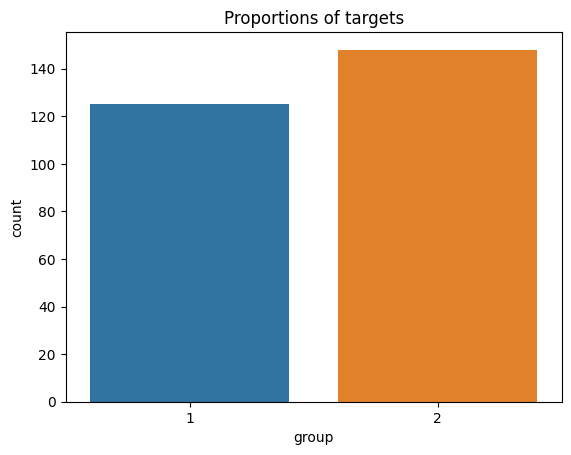

,Unnamed: 0,Gender,Age,Schooling,Breastfeeding,Varicella,Initial_Symptom,Mono_or_Polysymptomatic,Oligoclonal_Bands,LLSSEP,ULSSEP,VEP,BAEP,Periventricular_MRI,Cortical_MRI,Infratentorial_MRI,Spinal_Cord_MRI,group
0,0,1,34,20.0,1,1,2.0,1,0,1,1,0,0,0,1,0,1,1
1,1,1,61,25.0,3,2,10.0,2,1,1,0,1,0,0,0,0,1,1
2,2,1,22,20.0,3,1,3.0,1,1,0,0,0,0,0,1,0,0,1
3,3,2,41,15.0,1,1,7.0,2,1,0,1,1,0,1,1,0,0,1
4,4,2,34,20.0,2,1,6.0,2,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268,268,2,31,8.0,3,1,9.0,2,0,0,0,0,0,0,0,0,0,2
269,269,1,21,15.0,3,3,5.0,2,1,0,0,0,0,0,0,0,1,2
270,270,2,19,12.0,3,3,13.0,2,0,1,1,1,0,0,0,0,1,2
271,271,2,32,15.0,3,3,15.0,2,1,1,1,1,0,1,1,1,0,2


In [47]:
class Load_Preprocess():
    def __init__(self, path='conversion_predictors_of_clinically_isolated_syndrome_to_multiple_sclerosis.csv'):
        self.df = pd.read_csv(path)
        self.Target_proportions()

    def Target_proportions(self):
        self.df.drop('Unnamed: 0', axis=1)
        self.df.at[204,'Schooling'] = 20.0
        self.df.at[238,'Initial_Symptom'] = 8.0  # Use the most common value (just one value missing)
        self.df = self.df.drop('Initial_EDSS', axis=1)
        self.df = self.df.drop('Final_EDSS', axis=1)
        print(self.df.info())
        sns.countplot(x=self.df['group']).set_title('Proportions of targets')
        plt.show()

    def Preprocessing(self):
        X = self.df.iloc[:, 0:16].to_numpy()
        y = self.df.iloc[:, 16].to_numpy()

        # Scale the the features
        # scaler = StandardScaler()
        # X = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

        # X_under, y_under = self.Rebalance_Target_Data(X_train, y_train)

        return X_train, X_val, X_test, y_train, y_val, y_test

LP = Load_Preprocess()
X_train, X_val, X_test, y_train, y_val, y_test = LP.Preprocessing()
LP.df

In [48]:
X_train.shape, y_train.shape, X_val.shape, X_test.shape, y_val.shape, y_test.shape

((218, 16), (218,), (27, 16), (28, 16), (27,), (28,))

In [49]:
class MS_Dataset(Dataset):
    def __init__(self, Features, Labels):
        self.features = Features
        self.labels = Labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x, y = self.features[idx], self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

train_data = MS_Dataset(X_train, y_train)
val_data = MS_Dataset(X_val, y_val)
test_data = MS_Dataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)#, drop_last=True
val_loader = DataLoader(val_data, batch_size=256, shuffle=False)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

In [50]:
train_data.__len__(), val_data.__len__(), test_data.__len__(),

(218, 27, 28)

In [51]:
train_data.__getitem__(0)#, val_data.__getitem__(0), test_data.__getitem__(0),

(tensor([33.,  1., 38., 15.,  2.,  1.,  3.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,
          0.,  0.]),
 tensor(1))

In [52]:
train_data.__getitem__(0)[0].shape

torch.Size([16])

In [72]:
class MS_Classier(pl.LightningModule):
    def __init__(self):
        super(MS_Classier, self).__init__()
        self.hidden1 = nn.Linear(16, 256)
        self.dropout = nn.Dropout(p=0.25)
        self.hidden2 = nn.Linear(256, 128)
        self.bn = nn.BatchNorm1d(128)
        self.hidden3 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(p=0.25)
        self.hidden4 = nn.Linear(128, 32)
        self.output = nn.Linear(32, 2)

        # self.activation = nn.ReLU(inplace=True)
        self.activation = nn.LeakyReLU(0.25)
        self.CE = nn.CrossEntropyLoss()
        # self.CE = nn.BCEWithLogitsLoss()

    def forward(self, x):
        out = self.activation(self.hidden1(x))
        out = self.dropout(out)
        out = self.activation(self.hidden2(out))
        out = self.bn(out)
        out = self.activation(self.hidden3(out))
        out = self.dropout(out)
        out = self.activation(self.hidden4(out))

        out = self.output(out)
        return out

    def training_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)

        loss = self.CE(preds, labels)
        acc = ACC(preds, labels, task="multiclass", num_classes=2)

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)

        loss = self.CE(preds, labels)
        acc = ACC(preds, labels, task="multiclass", num_classes=2)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, test_batch, batch_idx):
        images, labels = test_batch
        preds = self.forward(images)

        loss = self.CE(preds, labels)
        acc = ACC(preds, labels, task="multiclass", num_classes=2)

        self.log('test_loss', loss)
        self.log('test_acc', acc, prog_bar=True)

    def predict_step(self, test_batch, batch_idx):
        images, labels = test_batch
        preds = self.forward(images)

        # Apply softmax to get probability distribution over classes
        probabilities = F.softmax(preds, dim=1)

        # Get class predictions by finding the class with the highest probability
        _, predicted_classes = torch.max(probabilities, dim=1)

        return predicted_classes.tolist()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)
        # return torch.optim.SGD(self.parameters(), lr=0.0001)

In [73]:
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Model = MS_Classier().to(device)
print(Model)
device

MS_Classier(
  (hidden1): Linear(in_features=16, out_features=256, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden3): Linear(in_features=128, out_features=128, bias=True)
  (hidden4): Linear(in_features=128, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=2, bias=True)
  (activation): LeakyReLU(negative_slope=0.25)
  (CE): CrossEntropyLoss()
)


'cuda'

In [74]:
trainer = pl.Trainer(max_epochs=100, gradient_clip_val=1.0)#, gradient_clip_val=1.0
trainer.fit(Model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | hidden1    | Linear           | 4.4 K 
1 | dropout    | Dropout          | 0     
2 | hidden2    | Linear           | 32.9 K
3 | bn         | BatchNorm1d      | 256   
4 | hidden3    | Linear           | 16.5 K
5 | hidden4    | Linear           | 4.1 K 
6 | output     | Linear           | 66    
7 | activation | LeakyReLU        | 0     
8 | CE         | CrossEntropyLoss | 0     
------------------------------------------------
58.2 K    Trainab

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=lightning_logs/

In [75]:
predictions = trainer.predict(Model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [76]:
np.array(predictions[0])

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [77]:
accuracy = accuracy_score(y_test,np.array(predictions[0]))*100
confusion_mat = confusion_matrix(y_test,np.array(predictions[0]))
print("Accuracy is:", round(accuracy, 1))
print("Confusion Matrix")
print(confusion_mat)

Accuracy is: 60.7
Confusion Matrix
[[15  1]
 [10  2]]
